# Import

In [1]:
import numpy as np
from scipy.linalg import toeplitz
from sys import getsizeof
from timeit import default_timer as time
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from numpy.linalg import inv
import functions_eq_mag as fc
import functions_fatiando as ft
import fourier_continuation as fc_c
import pickle as pickle
%matplotlib inline

# Observation and Equivalent layer grids

In [2]:
# Create a regular grid at 0m height
area = [-5000., 5000., -4000., 4000.]
shape = (80, 80)
N = shape[0]*shape[1]
xi, yi, zi = ft.gridder_regular(area, shape, z=-900.)
xi_plot, yi_plot, = xi/1000, yi/1000

# Equivalent Layer
areaj = [-5000., 5000., -4000., 4000.]
shapej = (80, 80)
Nj = shapej[0]*shapej[1]
xj, yj, zj = ft.gridder_regular(areaj, shapej, z=50)

# Model
verts1 = [[2000, -3000], [4000, -3000], [4000, 1000], [2000, 1000]]
#verts2 = [[-2000, 1000], [1000, 1000], [1000, 3000], [-2000, 3000]]
verts2 = [[-2000, 2000], [0, 2000], [0, 6000], [-2000, 6000]]
model_prism = [ft.mesher_PolygonalPrism(verts1, 900., 1500., props={'magnetization':[2,2,0]}),
               ft.mesher_PolygonalPrism(verts2, 700., 1100., props={'magnetization':[2,2,0]})]

R = 1000 #Radius
xc, yc, zc = -3000.,-2000.,2000. #Center of sphere
model_sphere = [ft.mesher_Sphere(xc, yc, zc, R, props={'magnetization':[2,2,0]})]

In [3]:
# Magnetic Configuration
inc0 = np.deg2rad(10.)
dec0 = np.deg2rad(37.)
inc = np.deg2rad(10.)
dec = np.deg2rad(37.)

F = np.array([np.cos(inc0)*np.cos(dec0), np.cos(inc0)*np.sin(dec0), np.sin(inc0)])
h = np.array([np.cos(inc)*np.cos(dec), np.cos(inc)*np.sin(dec), np.sin(inc)])

In [4]:
tf_prism = ft.polyprism_tf(xi, yi, zi, model_prism, inc0, dec0)
tf_sphere = ft.sphere_tf(xi, yi, zi, model_sphere, inc0, dec0)
tf = tf_prism + tf_sphere
tf = ft.utils_contaminate(tf, 0.5, seed=0, percent=False)

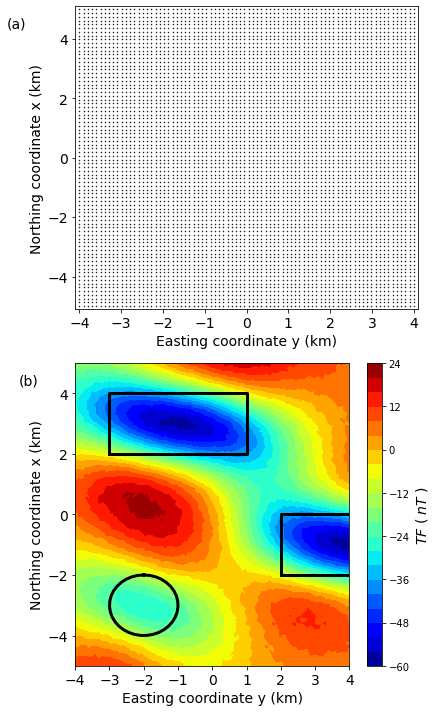

In [5]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.17, fontsize=14)
plt.plot(yi_plot, xi_plot, 'ko', alpha=1, ms=0.5)
plt.xlim(np.min(yi_plot)-0.1,np.max(yi_plot)+0.1)
plt.ylim(np.min(xi_plot)-0.1,np.max(xi_plot)+0.1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.17, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
#plt.plot(yi, xi, 'ko-', alpha=0.1)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout()
#plt.savefig('figures/model_mag_synthetic.png', dpi=300)

# Classic Forward Problem Construction - MAG

In [6]:
# Calculo da matriz de sensibilidade
s = time()
p_c, tf_c = fc.classic_mag(xi,yi,zi,zj,F,h,N,tf)
e = time()
tcpu = e - s
print (tcpu)

16.8680223


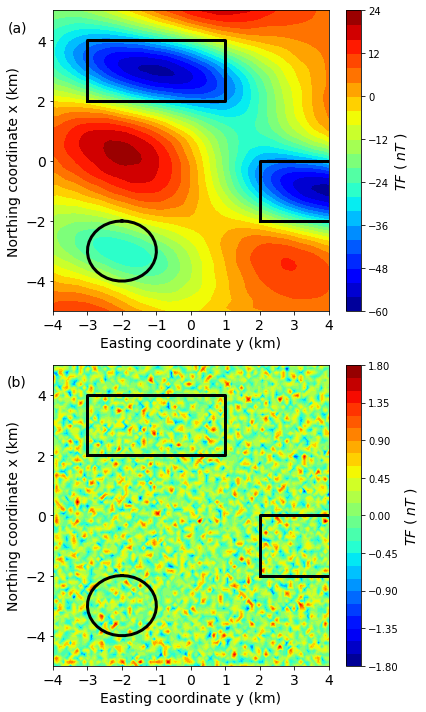

In [7]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_c,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf = tf-tf_c
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_synthetic_mag.png', dpi=300)

In [8]:
mean = np.mean(np.abs(delta_tf))
print (mean)
std = np.std(np.abs(delta_tf))
print (std)

0.37123135197907975
0.27982218720252916


## Parameter Plot

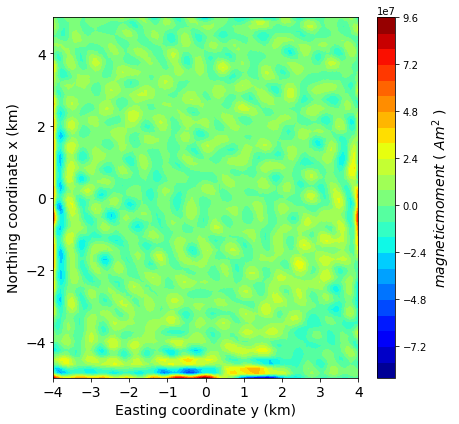

In [24]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_c,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/classic_fast.png', dpi=300)

# Conjugate Gradient Least Square

### Aster CGLS implementation - no conditioning

In [9]:
itmax = 50
t = time()
p_cgls, tf_cgls = fc.cgls_eq_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
w = time()
tcpu_cgls = w - t
print (tcpu_cgls)

5.366721699999999


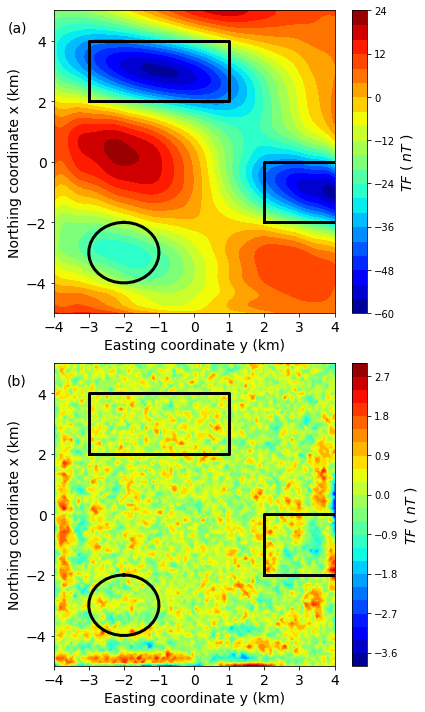

In [10]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_cgls,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf2 = tf-tf_cgls
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf2,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_cgls_mag.png', dpi=300)

In [11]:
mean = np.mean(np.abs(delta_tf2))
print (mean)
std = np.std(np.abs(delta_tf2))
print (std)

0.5124060666424048
0.4343628071245406


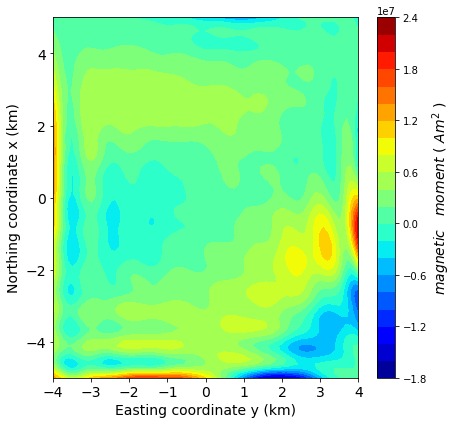

In [15]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_cgls,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/p_cgls.png', dpi=300)

### BCCB  matrix-vector product with Linear CGLS implementation - no conditioning

In [12]:
w = time()
itmax = 50
p_bccb,tf_bccb = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,itmax)
t = time()
tcpu = t - w
print (tcpu)

0.17275709999999833


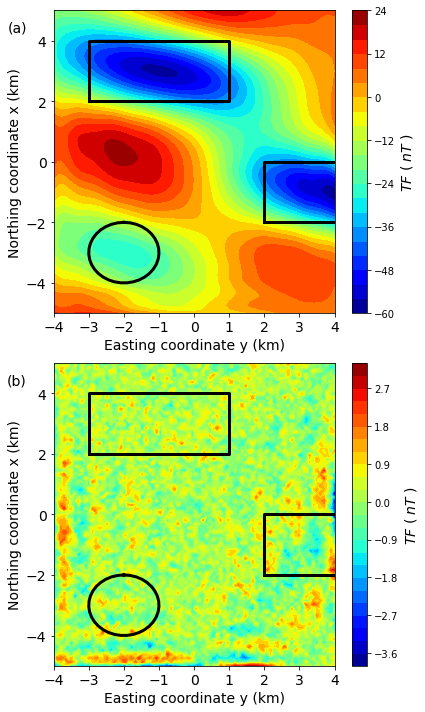

In [13]:
fig = plt.figure(figsize=(6,10))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(211)
plt.title('(a)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_bccb,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

delta_tf3 = tf-tf_bccb
plt.subplot(212)
plt.title('(b)', y=0.91, x=-0.13, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf3,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/predicted_bccb_mag.png', dpi=300)

In [14]:
mean = np.mean(np.abs(delta_tf3))
print (mean)
std = np.std(np.abs(delta_tf3))
print (std)

0.5150364162760016
0.4362780816504269


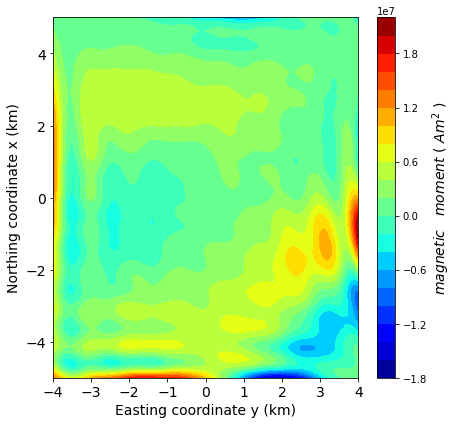

In [19]:
fig = plt.figure(figsize=(6.5,6))
fig.patch.set_facecolor('xkcd:white')
plt.tricontourf(yi_plot, xi_plot,p_bccb,22,cmap='jet')
cb = plt.colorbar(shrink=1)
cb.set_label('$magnetic \quad moment$ ( $Am^2$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/p_bccb.png', dpi=300)

## CGLS Convergence

In [15]:
itmax = np.arange(1,80,1)
res_list_ls = []
for k in itmax:
    p_cgls2,dobs_cgls2 = fc.cgls_eq_bccb_mag(xi,yi,zi,zj,shape,tf,F,h,k)
    norm_res_ls = np.linalg.norm(tf-dobs_cgls2)/N
    res_list_ls.append(norm_res_ls)

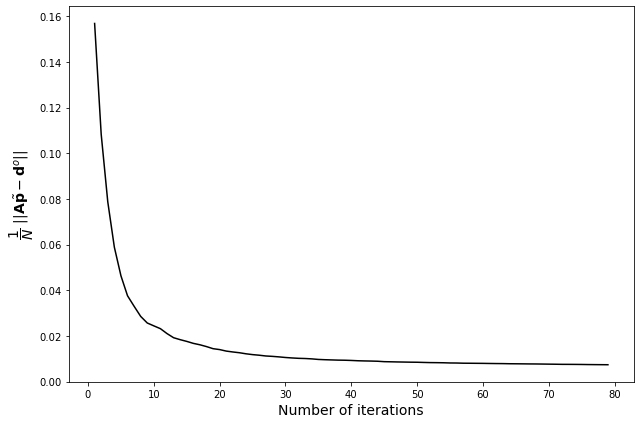

In [16]:
fig = plt.figure(figsize=(9,6))
fig.patch.set_facecolor('xkcd:white')
plt.plot(itmax,res_list_ls, 'k-')
plt.xlabel('Number of iterations', fontsize=14)
plt.ylabel('$\dfrac{1}{N} \,\,||\mathbf{A} \~{\mathbf{p}} - \mathbf{d}^o||$', fontsize=14)
plt.tight_layout();
#plt.savefig('figures/convergence_synthetic_mag.png', dpi=300)

## Upward and Downward continuation Fourier comparison

### True upward and downward data

In [17]:
zi_up = np.ones_like(zi)*(-1300)
tf_prism_up = ft.polyprism_tf(xi, yi, zi_up, model_prism, inc0, dec0)
tf_sphere_up = ft.sphere_tf(xi, yi, zi_up, model_sphere, inc0, dec0)
tf_up = tf_prism_up + tf_sphere_up
#tf_up = ft.utils_contaminate(tf_up, 0.5, seed=0, percent=False)

In [18]:
zi_down = np.ones_like(zi)*(-500)
tf_prism_down = ft.polyprism_tf(xi, yi, zi_down, model_prism, inc0, dec0)
tf_sphere_down = ft.sphere_tf(xi, yi, zi_down, model_sphere, inc0, dec0)
tf_down = tf_prism_down + tf_sphere_down
#tf_down = ft.utils_contaminate(tf_down, 0.5, seed=0, percent=False)

### Classical equivalent layer upward and downward

In [19]:
s = time()
A_up = fc.sensibility_matrix(xi,yi,zi_up,zj,F,h,N)
tf_classical_up = A_up.dot(p_c)
e = time()
tcpu = e - s
print (tcpu, 'seconds')

4.008203499999993 seconds


In [20]:
s = time()
A_down = fc.sensibility_matrix(xi,yi,zi_down,zj,F,h,N)
tf_classical_down = A_down.dot(p_c)
e = time()
tcpu = e - s
print (tcpu, 'seconds')

4.001427099999987 seconds


### CGLS BCCB equivalent layer upward and downward

In [21]:
s = time()
bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up = fc.bttb_mag(xi, yi, zi_up, zj, F, h, shape)
cev_up = fc.cev_mag(bttb_0_up, bttb_1_up, bttb_2_up, bttb_3_up, shape, N)
tf_bccb_up = fc.fast_forward_bccb_mag(cev_up, p_bccb, shape, N)
e = time()
tcpu = e - s
print (tcpu)

0.008692499999995107


In [22]:
s = time()
bttb_0_down, bttb_1_down, bttb_2_down, bttb_3_down = fc.bttb_mag(xi, yi, zi_down, zj, F, h, shape)
cev_down = fc.cev_mag(bttb_0_down, bttb_1_down, bttb_2_down, bttb_3_down, shape, N)
tf_bccb_down = fc.fast_forward_bccb_mag(cev_down, p_bccb, shape, N)
e = time()
tcpu = e - s
print (tcpu)

0.012454800000000432


### Fourier upward and downward

In [23]:
tf_fourier_up = fc_c.upcontinue(xi, yi, tf, shape, 400)

tf_fourier_down = fc_c.upcontinue(xi, yi, tf, shape, -400);

C:\Users\diego\Repositories\EQ_Layer_Mag-Toeplitz\code\fourier_continuation.py:56: UserWarning: Using 'height' <= 0 means downward continuation, which is known to be unstable.
  warnings.warn("Using 'height' <= 0 means downward continuation, " +


### Plot the upward continuations residuals

In [24]:
# define the scale for residuals
delta_tf_classical_up = tf_up-tf_classical_up
delta_tf_bccb_up = tf_up-tf_bccb_up
delta_tf_fourier_up = tf_up-np.ravel(tf_fourier_up)
scale_max = np.max(delta_tf_fourier_up)
scale_min = np.min(delta_tf_fourier_up)
colorbar_ranges = np.linspace(-20, 20, 21)
print (scale_min, scale_max)

-16.012027759214373 17.695532305282228


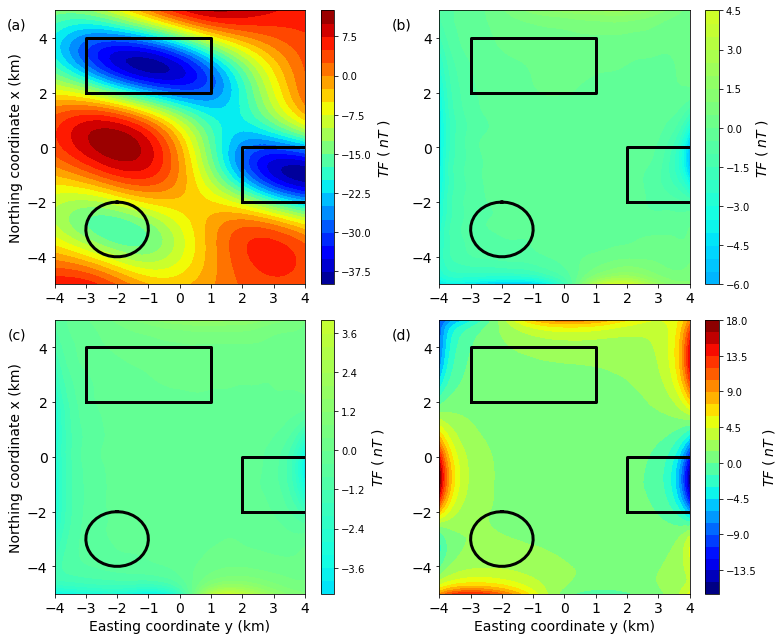

In [25]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_up,22, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_bccb_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_classical_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_fourier_up,22, vmin=scale_min, vmax=scale_max, cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('figures/upward_regular.png', dpi=300)

In [26]:
print (np.mean(np.abs(delta_tf_classical_up)))
print (np.mean(np.abs(delta_tf_bccb_up)))
print (np.mean(np.abs(delta_tf_fourier_up)))

print (np.std(np.abs(delta_tf_classical_up)))
print (np.std(np.abs(delta_tf_bccb_up)))
print (np.std(np.abs(delta_tf_fourier_up)))

0.5172517930186354
0.618364149293749
2.117588104639941
0.6585828449852436
0.8266281271309315
2.309052104489221


### Plot the downward continuations residuals

In [27]:
# define the scale for residuals
delta_tf_classical_down = tf_down-tf_classical_down
delta_tf_bccb_down = tf_down-tf_bccb_down
delta_tf_fourier_down = tf_down-np.ravel(tf_fourier_down)
scale_max = np.max(tf_fourier_down)
scale_min = np.min(tf_fourier_down)
colorbar_ranges = np.linspace(-45, 15, 21)
print (scale_min, scale_max)

-1207549.7942351312 1229501.8073937034


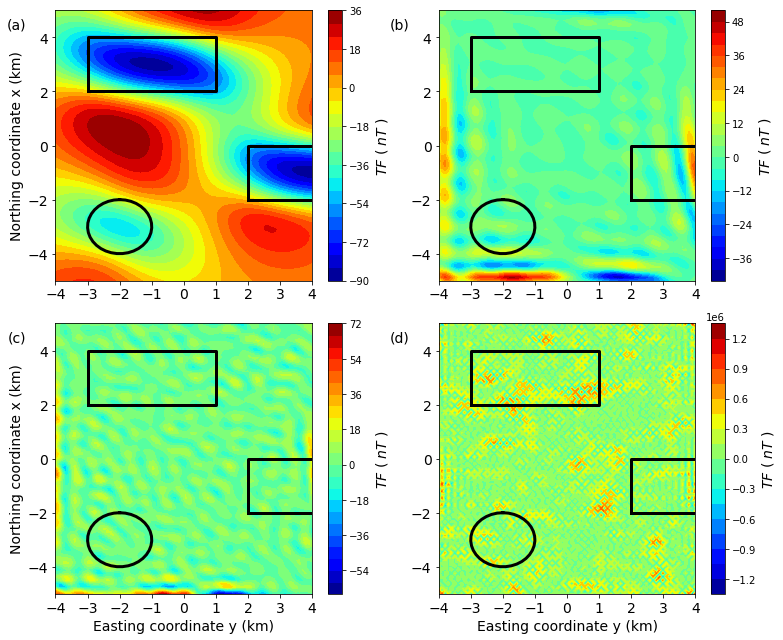

In [28]:
#Projection_model 
phi = np.linspace(0, 2.*np.pi, 36)  #36 points
x = xc/1000 + R/1000*np.cos(phi)
y = yc/1000 + R/1000*np.sin(phi)

x_p = [-3., -3, 1, 1, -3.]
y_p = [2., 4, 4, 2, 2.]

x_p2 = [2, 2, 6, 6, 2]
y_p2 = [-2, 0, 0, -2, -2.]

fig = plt.figure(figsize=(11,9))
fig.patch.set_facecolor('xkcd:white')
plt.subplot(221)
plt.title('(a)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,tf_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(222)
plt.title('(b)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_bccb_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(223)
plt.title('(c)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_classical_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.subplot(224)
plt.title('(d)', y=0.91, x=-0.15, fontsize=14)
plt.tricontourf(yi_plot, xi_plot,delta_tf_fourier_down,22,cmap='jet')
plt.plot(x_p,y_p,color="k", linewidth=3)
plt.plot(x_p2,y_p2,color="k", linewidth=3)
plt.plot(y, x, color="k", linewidth=3)
cb = plt.colorbar(shrink=1)
cb.set_label('$TF$ ( $nT$ )', rotation=90, fontsize=14)
plt.xlim(np.min(yi_plot),np.max(yi_plot))
plt.ylim(np.min(xi_plot),np.max(xi_plot))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Easting coordinate y (km)', fontsize=14)
#plt.ylabel('Northing coordinate x (km)', fontsize=14)

plt.tight_layout()
#plt.savefig('figures/downward_regular.png', dpi=300)

# Save the data

In [29]:
synthetic_regular = dict()
synthetic_regular['x'] = xi_plot
synthetic_regular['y'] = yi_plot
synthetic_regular['z'] = zi
synthetic_regular['tf'] = tf
synthetic_regular['p_c'] = p_c
synthetic_regular['tf_c'] = tf_c
synthetic_regular['delta_tf'] = delta_tf
synthetic_regular['p_bccb'] = p_bccb
synthetic_regular['tf_bccb'] = tf_bccb
synthetic_regular['delta_tf_bccb'] = delta_tf3
synthetic_regular['itmax'] = itmax
synthetic_regular['res_list_ls'] = res_list_ls
synthetic_regular['tf_up'] = tf_up
synthetic_regular['delta_tf_classical_up'] = delta_tf_classical_up
synthetic_regular['delta_tf_bccb_up'] = delta_tf_bccb_up
synthetic_regular['delta_tf_fourier_up'] = delta_tf_fourier_up
synthetic_regular['tf_down'] = tf_down
synthetic_regular['delta_tf_classical_down'] = delta_tf_classical_down
synthetic_regular['delta_tf_bccb_down'] = delta_tf_bccb_down
synthetic_regular['delta_tf_fourier_down'] = delta_tf_fourier_down


#save the data
file_name = 'synthetic_regular_tf.pickle'
with open(file_name, 'wb') as f:
    pickle.dump(synthetic_regular, f)